# Japanese fake news classification

We're going to attempt to classify this dataset. This is a dataset featuring Japanese news articles, from which a part
real, some are half fake, and some are entirely fake.

0: Original article
1: Partially fake
2: Completely fake

Source: [Japanese fakenews dataset](https://www.kaggle.com/tanreinama/japanese-fakenews-dataset)

## Inspection

In [20]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sudachipy import tokenizer, dictionary
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, LeakyReLU
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.regularizers import l2

physical_devices = tf.config.list_physical_devices('GPU')
for i in physical_devices:
    tf.config.experimental.set_memory_growth(i, enable=True)

df = pd.read_csv("fakenews.csv")
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
isfake,13040.0,1.075613,0.796950,0.0,0.0,1.0,2.00,2.0
nchar_real,13040.0,261.029371,288.257753,0.0,0.0,215.0,407.00,4447.0
nchar_fake,13040.0,328.273160,354.673240,0.0,0.0,255.0,489.25,2582.0


In [2]:
print(f'Rows/Columns: {df.shape}')
print(f"Class distribution is: \n{df['isfake'].value_counts()}\n")
print(df.isnull().sum())

Rows/Columns: (13040, 5)
Class distribution is: 
1    4684
2    4671
0    3685
Name: isfake, dtype: int64

id            0
context       0
isfake        0
nchar_real    0
nchar_fake    0
dtype: int64


From what we can see the dataset does not contain null values, and it's class distribution is mostly even.

Although mostly even, not perfectly even, so while my first thought was accuracy as a metric, I've decided to opt for
F1 score as well. So I'm gonne be using accuracy as a training validation metric, and F1 as a test metric.

In [3]:
print(df['context'].head())

0    朝日新聞など各社の報道によれば、宅配便最大手「ヤマト運輸」が日本郵政公社を相手取り、大手コン...
1    11月5日の各社報道によると、諫早湾干拓事業は諫早海人（諫早湾の「海」）に囲まれる大洋に位置...
2    産経新聞、中日新聞によると、2004年から2005年まで、この大会による3年おきの開催を、2...
3    開催地のリオデジャネイロ市に対して、大会期間中のリオデジャネイロオリンピックに関する公式発表...
4    毎日新聞・時事通信によると、2006年2月13日には、グッドウィル・グッゲンハイム・アン・ハ...
Name: context, dtype: object


## Preprocessing

We can mostly follow the standard NLP cleaning methods, albeit with a catch, it's a character based language, so the
traditional packages such as NLTK won't work. That's why we need to find substitutes for the cleaning methods. Let's go
over them:

I've decided to go with [SudachiPy](https://pypi.org/project/SudachiPy/) for tokenization and stemming
[stopwords-ja](https://github.com/stopwords-iso/stopwords-ja/blob/master/stopwords-ja.json) (link to json file) for stopword removal.

I decided to not use lemmatization, since there are a lot of words that might _seem_ similar, but are vastly different
taking into account their context.

### Removing features

Everything besides the actual text and the label class is just noise, so we'll take those out.

In [4]:
len_df = len(df)
df = df.head(int(len_df / 2))

labels = df.pop('isfake')
labels = to_categorical(labels, 3)
data = df.pop('context')

### Tokenization

We're going to tokenize our sentences. This we'll do with Sudachi, a morphological analyzer. The short version of
what that means is that we're splitting our sentences up into pieces, aka tokens. We need a specialized analyzer for
this task, because you can't just randomly split it up by character, because then you'd lose context. After tokenization
is complete we can do the rest of the preprocessing steps, which we usually apply individually per character.

### Special characters

We need to also remove some special characters that will be of no use to the classifier, think of stuff such as commas
and question marks, etc. We do this via a regex filter. I spent some time looking for the exactly right one online,
since I wanted to keep all japanese characters, but remove junk such as symbols. Speaking of symbols for some reason
the Japanese have their own version of them for some reason (。、？  notice how they're different?), which is pretty
tricky. While you'd want to remove irrelevant characters, you also don't want to remove all symbols, since some are
very important to the language (e.g. ー, which lengthens vowels.).

The conclusion here is that you'll have to build your own japanese regex filter to suit your exact needs. Definitely
check out [this gist](https://gist.github.com/terrancesnyder/1345094) for that.

Check out the pre-processing function below for the specific regex i used.

### Stemming

Stemming implies reducing the form of a word to its stem. E.g. 食べている -->　食べる, した　--> する. This is useful to
reduce the amount of variants of a word which mostly mean the exact same thing (from the perspective of the model)

### Stopwords

Stopword removal implies the removal of certain words which appear in an excessive frequency in the language. Common
examples for English are "the", "and" and so forth. These are useful to remove because they lose meaning viewed
individually.

In [5]:
def sample(data, limit=3):
    """
    Quick util method to display samples of the sentences
    :param data: collection
    :param limit: how much samples to show
    """
    for x in range(0, limit, 1):
        print(f"{data[x]}\n")


sample(data)

朝日新聞など各社の報道によれば、宅配便最大手「ヤマト運輸」が日本郵政公社を相手取り、大手コンビニエンスストア「ローソン」でのサービス提供の差し止めなどを求めていた訴訟で、2006年1月19日、東京地方裁判所でヤマト運輸の請求を棄却する判決が下された。2004年のローソンでの郵便小包サービス「ゆうパック」の受付業務開始に際し、ヤマト運輸は「独占禁止法に違反する不当な廉売」として、日本郵政公社を相手取り、サービス提供の差し止めなどを求めていた。朝日新聞によれば、提訴の内容は、2004年11月のローソンでの「ゆうパック」の受付サービス提供の開始に関連し、租税などの優遇措置を受けている日本郵政公社が、配送料金（運賃）などの有利な取引条件でローソンで「ゆうパック」を開始させたのは、独占禁止法の不当廉売に当たり、ヤマト運輸の利益を侵害されるとして、「ゆうパック」サービス提供の差し止めなどを求めていたもの。朝日新聞によれば、判決内容はヤマト運輸の主張を全面的に否定しており、今後の「ゆうパック」サービスの拡大に弾みがつくものと考えられる。日本郵政公社は、公正妥当な判決とのコメントを出した。一方、ヤマト運輸は、高等裁判所への控訴など、今後の対応については検討するとアナウンスしている。

11月5日の各社報道によると、諫早湾干拓事業は諫早海人（諫早湾の「海」）に囲まれる大洋に位置することから、人身売買により、環境問題に加え、環境保護にも関心が向けられた。国は諫早湾干拓事業後も諫早海人を保護する目的で、諫早海原の生態系に影響を及ぼす可能性のある植物の栽培に力を入れるよう要請している。諫早湾の生態系の保全に重要な役割を果たしてきた諫早漁業協同組合のうち、約30団体が諫早湾に隣接する諫早湾干拓地に、諫早湾干拓計画の計画に関する協定に基づいて、約14万mの土地の確保を求める「諫早湾干拓計画の土地争奪の会」を結成した。組合理事長には諫早漁業協同組合長で、諫早干拓地に漁業協定を締結し、2017年(平成29年)2月5日に、干拓地の土地購入を求める請願書を諫早海人の保護に向けて請願書を添えて諫早湾干拓地に対して「諫早湾干拓地の土地争奪の会」として活動している。

産経新聞、中日新聞によると、2004年から2005年まで、この大会による3年おきの開催を、2006年から2年連続で実施したことがある。また、

In [6]:
def pre_process_text(text, stopwords, tokenizer_obj):
    """
    Cleans the text of unnecessary features
    :param text: sentence to clean
    :param stopwords: list of very commonly used words
    :param tokenizer_obj: SudachiPy tokenizer object
    :return: cleaned string
    """
    # One by one: (kanji), (hiragana and katakana), (western alphabet and numbers), (western alphabet and numbers
    # except it's the off-looking japanese version), the vowel extending symbol and unicode flag
    pattern = re.compile(r'([一-龯]+)|([ぁ-んァ-ン]+)|([a-zA-Z0-9]+)|([ａ-ｚＡ-Ｚ０-９]+)|[ー+]', re.UNICODE)
    text = ''.join([x.group() for x in re.finditer(pattern, text.lower().strip())])

    # Tokenizes, converts to dictionary form, and doesn't add it if it's in the stopword list
    lst_text = [m.dictionary_form() for m in tokenizer_obj.tokenize(text, mode) if m not in stopwords]

    # Rejoin tokenized string
    text = " ".join(lst_text)
    return text


tokenizer_obj = dictionary.Dictionary().create()
mode = tokenizer.Tokenizer.SplitMode.C
lst_stopwords = requests.get(
    'https://raw.githubusercontent.com/stopwords-iso/stopwords-ja/master/stopwords-ja.json').json()

print("Starting cleaning phase, this may take a few minutes...")
data = [pre_process_text(i, lst_stopwords, tokenizer_obj) for i in data]
sample(data, 5)

Starting cleaning phase, this may take a few minutes...
朝日新聞 など 各社 の 報道 に よる ば 宅配便 最大手 ヤマト 運輸 が 日本郵政 公社 を 相手 取る 大手 コンビニエンスストアローソン で の サービス 提供 の 差し止め など を 求める て いる た 訴訟 で 2006 年 1 月 19 日 東京 地方裁判所 で ヤマト 運輸 の 請求 を 棄却 する 判決 が 下す れる た 2004 年 の ローソン で の 郵便 小包 サービス ゆう パック の 受付 業務 開始 に 際する ヤマト 運輸 は 独占禁止法 に 違反 する 不当 だ 廉売 と する て 日本郵政 公社 を 相手 取る サービス 提供 の 差し止め など を 求める て いる た 朝日新聞 に よる ば 提訴 の 内容 は 2004 年 11 月 の ローソン で の ゆう パック の 受付 サービス 提供 の 開始 に 関連 する 租税 など の 優遇措置 を 受ける て いる 日本郵政 公社 が 配送 料金 運賃 など の 有利 だ 取引 条件 で ローソン で ゆう パック を 開始 する せる た の は 独占禁止法 の 不当廉売 に 当たる ヤマト 運輸 の 利益 を 侵害 する れる と する て ゆう パック サービス 提供 の 差し止め など を 求める て いる た もの 朝日新聞 に よる ば 判決 内容 は ヤマト 運輸 の 主張 を 全面的 だ 否定 する て おる 今後 の ゆう パック サービス の 拡大 に 弾み が つく もの と 考える られる 日本郵政 公社 は 公正 妥当 だ 判決 と の コメント を 出す た 一方 ヤマト 運輸 は 高等裁判所 へ の 控訴 など 今後 の 対応 に つく て は 検討 する と アナウンス する て いる

11 月 5 日 の 各社 報道 に よる と 諫早湾 干拓 事業 は 諫早 海人 諫早湾 の 海 に 囲む れる 大洋 に 位置 する こと から 人身 売買 に よる 環境 問題 に 加える 環境 保護 に も 関心 が 向ける られる た 国 は 諫早湾 干拓 事業 後 も 諫早 海人 を 保護 する 目的 で 諫早 海原 の 生態系

## NLP technique

Now we need to choose a technique to actually process this text, because after all, our neural network only accepts
numbers, not japanese characters. Some examples of the current most popular techniques are Bag of Words, TF_IDF Scheme,
BERT, word2vec.

I've decided to use word2vec here, which maps words and/or phrases to vectors. word2vec comes with 2 options, Skip Gram
and Continuous Bag of Words, which are essentially mirrored versions of each other. CBOW is trained to predict a single
word from multiple context words, SG is trained to predict multiple words from a single context word.

I used [this pre-trained skip-gram embedding](https://github.com/singletongue/WikiEntVec/releases) trained on wikipedia articles,
which i got from [this comparison of Japanese embeddings](https://blog.hoxo-m.com/entry/2020/02/20/090000) since i
felt like it fit with the vocabulary of our news articles.

To load our embeddings i used Gensim, since it's the easiest to use.

In [7]:
print("Loading word embedding into Gensim, this may take a while...")
w2vec_model = KeyedVectors.load_word2vec_format("jawiki.all_vectors.100d.txt", binary=False)

Loading word embedding into Gensim, this may take a while...


In [8]:
# Example of vocabulary in the w2vec model
vocabulary = w2vec_model.index_to_key
print(vocabulary[10:20], "\n")

# Example of how to access vector of a word
print(w2vec_model['から'])


['で', 'と', 'て', 'し', '-', '「', '」', '・', '.', 'れ'] 

[-0.05424202  0.1458669  -0.1505562  -0.24010111 -0.01950142 -0.28026608
 -0.24137759 -0.08544306  0.36346292 -0.11571427  0.23507327 -0.0971128
  0.1057099   0.20031585  0.23861915  0.04079442 -0.27873233  0.15673713
 -0.49063805 -0.02615511 -0.08692899  0.04598851 -0.54485244 -0.2860162
  0.33003595  0.29364508  0.07580052 -0.11194471  0.16311777  0.40613616
  0.07776039 -0.16600984  0.02905702 -0.60532445 -0.09457524 -0.3297473
 -0.01706993  0.45337644 -0.4131868  -0.44290012 -0.05127981  0.31429702
 -0.16551502  0.3934557  -0.06291522 -0.20458929 -0.16928542 -0.0633463
  0.11876631 -0.14330144 -0.10860962  0.37090102 -0.34425735  0.650237
 -0.24081106 -0.15542194  0.10929754  0.07190403 -0.06562193 -0.20213448
  0.08358574  0.10267685  0.71501976 -0.08622672 -0.3145801   0.14825802
 -0.16056281  0.11907483  0.05228252  0.18672475 -0.08462543  0.2993849
  0.18023452  0.17779335 -0.06018992 -0.04269223  0.13172042  0.6201566
 -0.19

In [9]:
weights = w2vec_model.vectors
vocabulary_length = weights.shape[0]
print(f"Imported word2vec model has {vocabulary_length} entries")

embedding_layer = Embedding(
    input_dim=weights.shape[0],
    output_dim=weights.shape[1],
    weights=[weights],
    trainable=False)

Imported word2vec model has 1511782 entries


In [10]:
t = Tokenizer()
t.fit_on_texts(data)
vocab_size = len(t.word_index) + 1

encoded_docs = t.texts_to_sequences(data)
print(encoded_docs[0])

padded_docs = pad_sequences(encoded_docs, padding='post', maxlen=1000)

[74, 33, 951, 1, 91, 2, 16, 52, 15692, 6489, 1995, 2408, 9, 6733, 2737, 6, 971, 571, 1996, 28608, 10, 1, 435, 430, 1, 6734, 33, 6, 195, 8, 11, 4, 676, 10, 246, 14, 25, 17, 141, 15, 83, 2049, 10, 1995, 2408, 1, 1866, 6, 3860, 3, 452, 9, 1227, 13, 4, 395, 14, 1, 5372, 10, 1, 5677, 12623, 435, 8442, 9997, 1, 7004, 827, 311, 2, 1803, 1995, 2408, 7, 12624, 2, 465, 3, 1646, 12, 28609, 5, 3, 8, 6733, 2737, 6, 971, 571, 435, 430, 1, 6734, 33, 6, 195, 8, 11, 4, 74, 2, 16, 52, 3977, 1, 226, 7, 395, 14, 59, 17, 1, 5372, 10, 1, 8442, 9997, 1, 7004, 435, 430, 1, 311, 2, 644, 3, 21778, 33, 1, 10694, 6, 69, 8, 11, 6733, 2737, 9, 5678, 2848, 4829, 33, 1, 4327, 12, 1193, 854, 10, 5372, 10, 8442, 9997, 6, 311, 3, 103, 4, 1, 7, 12624, 1, 28610, 2, 658, 1995, 2408, 1, 1084, 6, 800, 3, 13, 5, 3, 8, 8442, 9997, 435, 430, 1, 6734, 33, 6, 195, 8, 11, 4, 57, 74, 2, 16, 52, 452, 226, 7, 1995, 2408, 1, 204, 6, 5097, 12, 780, 3, 8, 70, 258, 1, 8442, 9997, 435, 1, 801, 2, 12625, 9, 47, 57, 5, 199, 43, 6733, 2737, 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, train_size=0.80, stratify=labels, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5)

In [12]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100,
               kernel_regularizer=l2(0.001),
               recurrent_regularizer=l2(0.001),
               bias_regularizer=l2(0.001)))
model.add(Dense(25, activation=LeakyReLU(0.1)))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(0.001, clipvalue=0.5),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [13]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
163/163 [==============================] - 16s 60ms/step - loss: 1.3556 - accuracy: 0.3703 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.2096 - val_accuracy: 0.3620 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

In [14]:
nn_pred = model.predict(X_test)
print(nn_pred[0:5])

[[0.29507732 0.35295665 0.35196605]
 [0.29507732 0.35295665 0.35196605]
 [0.29507732 0.35295665 0.35196605]
 [0.29507732 0.35295665 0.35196605]
 [0.29507732 0.35295665 0.35196605]]


In [22]:
f = f1_score(np.argmax(y_test, axis=1), np.argmax(nn_pred, axis=1), average='weighted')
print(f"F1 score is {f}")


F1 score is 0.19546220349741528


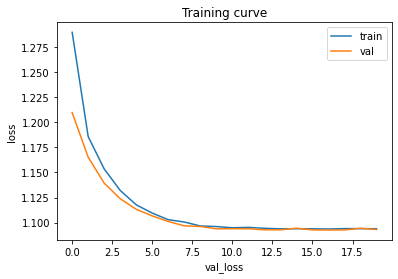

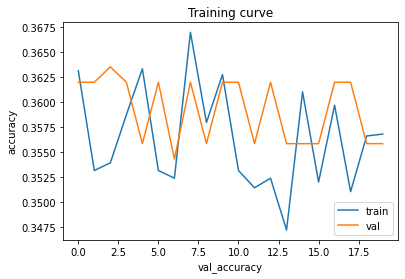

In [16]:
train_hist = hist.history['loss']
val_hist = hist.history['val_loss']
plt.plot(train_hist)
plt.plot(val_hist)
plt.title('Training curve')
plt.ylabel('loss')
plt.xlabel('val_loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

train_hist = hist.history['accuracy']
val_hist = hist.history['val_accuracy']
plt.plot(train_hist)
plt.plot(val_hist)
plt.title('Training curve')
plt.ylabel('accuracy')
plt.xlabel('val_accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Conclusion

As you can see, the results were absolutely abysmal. The model just keeps predicting the exact same values, leading
to a very poor F1 score. Looking at the training curves, we can see that the loss and val_loss are decreasing in a
pretty nice manner, but the accuracy curves are moving pretty much horizontally.

My first suspicion of what was  happening was exploding gradients, which is why I introduced gradient clipping and
L2 regularization, but this didn't fix the issue. Neither did switching from multiclass labels to one-hot encoded
multiclass labels help. Taking into account that my IDE regularly froze or crashed during the training phase,
presumably due to memory errors, I'm concluding that this problem is too complex for a home computer to solve. This
can be further confirmed if you take into account the amount of data we have (~13k), the amount of vocabulary
Japanese has (about 8-10k characters are commonly in use), and how large our word-embedding is (1.5 million!).


Package wise, we still have a long way to go. The Japanese equivalents of the NLP packages are more underveloped,
less reliable, and generally slower too. This can be mostly attributed to the language being difficult, but it's
definitely something you have to keep in mind while working with Japanese text. Research paper wise there's also
barely any material available on the topic, which leads me to believe that Japanese researchers aren't particularly
focusing on this area of AI. Maybe in a few years Japanese NLP will be in a good place.


## References

[Preprocessing Methods and Tools in Modelling Japanese for Text Classification](https://www.researchgate.net/publication/335337209_Preprocessing_Methods_and_Tools_in_Modelling_Japanese_for_Text_Classification)
Paper detailing tools for Japanese NLP analysis. A few years old, but still relevant as of current date.

[nlp-recipes-ja](https://github.com/upura/nlp-recipes-ja)
Github repository containing a ton of samples for Japanese text analysis in Python.

[Migrating from Gensim 3.0 to 4.0](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4)
Gensim recently upgraded to 4.0 release, which contains code-breaking API changes, and most recent material on gensim is
still using older versions.

[Gensim Keras embedding layer example](https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow)
How to create a Keras embedding layer with a Gensim model

[Using pretrained gensim Word2vec embedding in keras](https://stackoverflow.com/a/52126699/7174982)
Helpful answer on how to encode the text sequences